In [ ]:
from main import Value

In [ ]:
a = 2.0
b = -3.0
c = 10.0 
fn = lambda a,b,c: a*b+c 
print(fn(a,b,c)) 

In [ ]:
# https://en.wikipedia.org/wiki/Derivative 
# df/da = (f(a+h)-f(a))/h for infinitessimally small h 
h = 0.0001 
print('slope:', (fn(a+h,b,c) - fn(a,b,c)) / h)

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = fn(a,b,c); d.label = 'd'
print(d)

In [ ]:
d._op, d._prev

In [ ]:
from helpers import trace, draw_dot

In [ ]:
nodes, edges = trace(d)
print(f'{len(nodes)=} {len(edges)=}')

In [ ]:
draw_dot(d)

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = fn(a,b,c); d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; 
L.label = 'L'
print(L)

In [ ]:
draw_dot(L)

In [ ]:
def forward_pass(a,b,c,d,f):
    d = fn(a,b,c); d.label = 'd'
    L = d*f; 
    L.label = 'L'
    return L
L = forward_pass(a,b,c,d,f)
Ld = forward_pass(a, b, c, d+h, f)
La = forward_pass(a+h, b, c, d, f)
Lb = forward_pass(a, b+h, c, d, f)
Lc = forward_pass(a, b, c+h, d, f)
Lf = forward_pass(a, b, c, d, f+h)

In [ ]:
dL_wrt_dx = lambda L2, L1: (L2 - L1) / h
print(f'{dL_wrt_dx(L+h, L)=}')
print(f'{dL_wrt_dx(Ld, L)=}')
print(f'{dL_wrt_dx(Lf, L)=}')
print(f'{dL_wrt_dx(La, L)=}')
print(f'{dL_wrt_dx(Lb, L)=}')
print(f'{dL_wrt_dx(Lc, L)=}')

```
dL/dL = ((L+h)-L) / h = 1 
dL/dd = ((d+h)*f - d*f) / h = f 
dL/df = d 

dL/dc = dL/dd * dd/dc = f * d/dc (a*b+c) = f*1 = f = -2

let e = a*b
dL/de = dL/dd * dd/de = f * d/de (e+c) = f*1 = f = -2 

dL/da = dL/dd * dd/de * de/da = f * 1 * d/da (a*b) = f*b = -2*-3 = 6
dL/db  = f*a = -4 
```

In [ ]:
((d+h)*f - L)/h 

# MLP

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt

xs = np.arange(-5,5, 0.2)
ys = np.tanh(xs)
plt.plot(xs, ys); plt.grid(); 

In [ ]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735878195432, label='b')

n  = x1*w1 + x2*w2  + b 
n.label = 'n'
o = n.tanh()

In [ ]:
draw_dot(o)

In [ ]:
o.backward()

In [1]:
from main import Value 
from helpers import draw_dot

2*Value(2)
2+Value(2)
Value(2)-2

Value(0.0000E+00)

In [2]:
2-Value(2)
Value(4) / Value(2)

Value(2.0000E+00)

In [3]:
Value(4) / 2

Value(2.0000E+00)

In [4]:
x = 4 / Value(2)


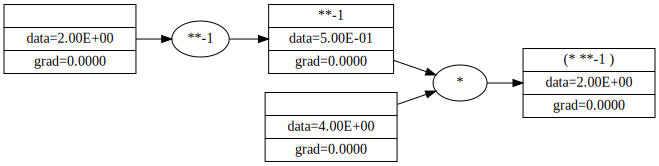

In [5]:
draw_dot(x)